# Star Classification

We have several columns : 

- obj_ID : Object identifier 
- alpha : Rigth ascension angle
- delta : Declination angle
- u : Ultaviolet filter in the photometric system
- g : Green filter in the photometric system
- r : Red filter in the photometric system
- i : Near infered filter in the photometric system
- z : Infrared filter in the photometric system
- run_ID : Run number used to identify specific scan
- rerun_ID : Rerun number used to specify how the image was processed
- calm_col : Camera column to identify scanline within the run 
- field_ID : Field number to identify each field
- spec_obj_ID : Unique ID used to optical spectroscopic object
- class : Object class (galaxy, quasar, star)
- redshift : Redshift value based on the increase in wavelength
- plate : Identify each plate in SDSS
- MJD : Modified "Julian" date, used to indicate when a given piece of SDSS data was taken
- fiber_ID : Identify the fiber that pointed the ligth at the focal plane in each observation   

In [2]:
#Imports 
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [3]:
#Read data
data = pd.read_csv("star_classification.csv")
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
#Column information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

We have 18 columns, 10 float type columns, 7 int type columns and 1 object type which is our target. It would seem we have no NaN in our dataset.

In [4]:
#Percent of NaN values
data.isna().sum()/data.shape[0]

obj_ID         0.0
alpha          0.0
delta          0.0
u              0.0
g              0.0
r              0.0
i              0.0
z              0.0
run_ID         0.0
rerun_ID       0.0
cam_col        0.0
field_ID       0.0
spec_obj_ID    0.0
class          0.0
redshift       0.0
plate          0.0
MJD            0.0
fiber_ID       0.0
dtype: float64

We have not NaN values in our dataset.

In [5]:
#Number of unique value for int type features
for col in data.select_dtypes('int64').columns :
    print(f"{col} -> {data[col].nunique()}") 

run_ID -> 430
rerun_ID -> 1
cam_col -> 6
field_ID -> 856
plate -> 6284
MJD -> 2180
fiber_ID -> 1000


We have only one value for rerun_ID column. And cam_col column can be interpreted as a categorical features.  
Well, we can drop rerun_ID and spec_obj_ID (individual for every entry).

In [5]:
#Drop useless features
data.drop(['spec_obj_ID', 'rerun_ID'], axis = 1, inplace = True)

Now we will encode cam_col feature with one hot encoding.

In [6]:
#One hot encoding
data = pd.get_dummies(data, columns = ['cam_col'])
data.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'field_ID', 'class', 'redshift', 'plate', 'MJD', 'fiber_ID',
       'cam_col_1', 'cam_col_2', 'cam_col_3', 'cam_col_4', 'cam_col_5',
       'cam_col_6'],
      dtype='object')

Our data is ready for visualization and analysis.

### Exploratory data analysis

First, wa can check the dataset target repartition.

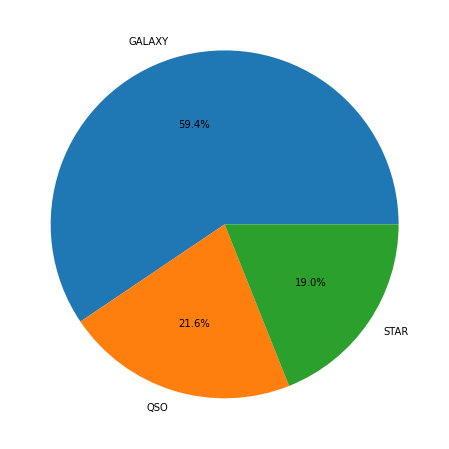

In [7]:
#Target balance
plt.figure(figsize = (12,8))
plt.pie(data['class'].value_counts(), labels = data['class'].unique(), autopct = "%1.1f%%")
plt.show()

We have a large majority of galaxy. So it is an imbalanced dataset.

To achieve good result during classification, we will use class weight penalization to make errors on the minority class more important than the majority class.

In [8]:
#Statistical analysis
data.describe().T

,count,mean,std,min,25%,50%,75%,max
obj_ID,100000.0,1.237665e+18,8.438560e+12,1.237646e+18,1.237659e+18,1.237663e+18,1.237668e+18,1.237681e+18
alpha,100000.0,1.776291e+02,9.650224e+01,5.527828e-03,1.275182e+02,1.809007e+02,2.338950e+02,3.599998e+02
delta,100000.0,2.413530e+01,1.964467e+01,-1.878533e+01,5.146771e+00,2.364592e+01,3.990155e+01,8.300052e+01
u,100000.0,2.198047e+01,3.176929e+01,-9.999000e+03,2.035235e+01,2.217913e+01,2.368744e+01,3.278139e+01
g,100000.0,2.053139e+01,3.175029e+01,-9.999000e+03,1.896523e+01,2.109983e+01,2.212377e+01,3.160224e+01
r,100000.0,1.964576e+01,1.854760e+00,9.822070e+00,1.813583e+01,2.012529e+01,2.104478e+01,2.957186e+01
i,100000.0,1.908485e+01,1.757895e+00,9.469903e+00,1.773228e+01,1.940514e+01,2.039650e+01,3.214147e+01
z,100000.0,1.866881e+01,3.172815e+01,-9.999000e+03,1.746068e+01,1.900460e+01,1.992112e+01,2.938374e+01
run_ID,100000.0,4.481366e+03,1.964765e+03,1.090000e+02,3.187000e+03,4.188000e+03,5.326000e+03,8.162000e+03
field_ID,100000.0,1.861305e+02,1.490111e+02,1.100000e+01,8.200000e+01,1.460000e+02,2.410000e+02,9.890000e+02


This analyse help us to understand the feature deviation, and we can see wee have outliers on u, g, z features. We will deal with it later.

But the next step is features correlation. It will help us to remove redundant features and imporve our model performance.

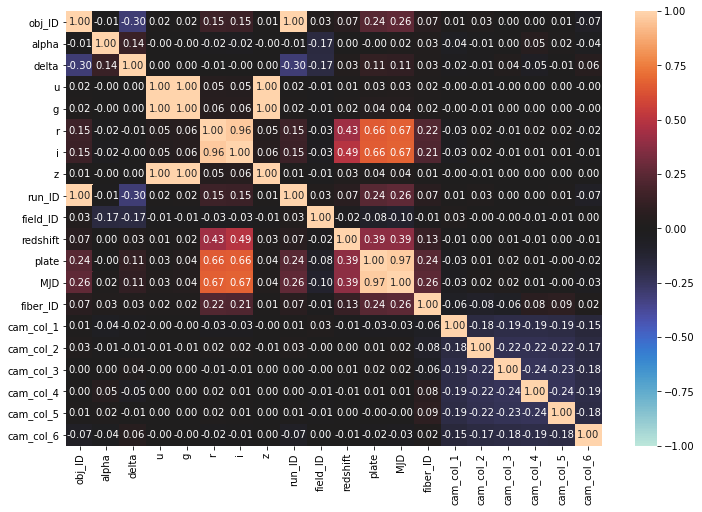

In [10]:
#Features correlation
plt.figure(figsize = (12,8))
sb.heatmap(data.corr(), annot = True, fmt = '.2f', vmax = 1, vmin = -1, center = 0)
plt.show()

We can see that we have high correlation on severals features. We will use Principal componant analysis to reduce the dataset dimensionality and improve performance model.

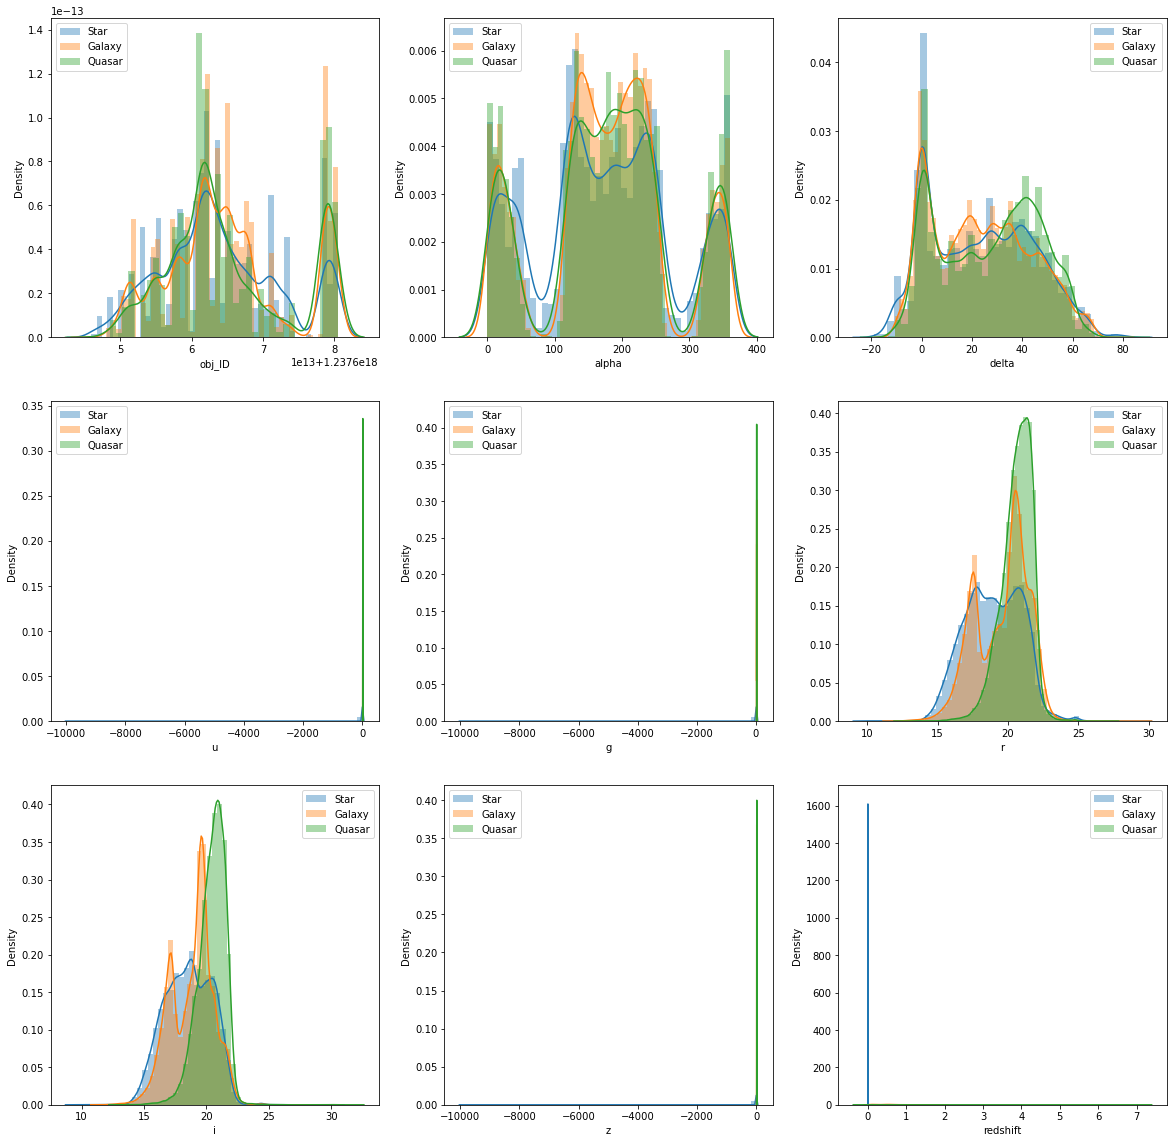

In [11]:
#Data distribution 
star_df = data[data['class'] == "STAR"]
galaxy_df = data[data['class'] == "GALAXY"]
quasar_df = data[data['class'] == "QSO"]


plt.figure(figsize=(20,20))
for index, col in enumerate(data.select_dtypes('float64').columns) : 
    plt.subplot(3, 3, index+1)
    sb.distplot(star_df[col], label="Star")
    sb.distplot(galaxy_df[col], label="Galaxy")
    sb.distplot(quasar_df[col], label="Quasar")
    plt.legend()
plt.show()

Some distribution plot are not significative due to outliers. But We can see large overlap on classes. Even if the Quasar seems to have different density on some features. This may lead to misclassification.

### Preprocessing

In [26]:
#Imports 
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier

First of all, we will convert to numeric our target, because machine learning algorithm don't understand characters.

In [12]:
#Convert target to numeric
def target(c) : 
    if c == "GALAXY" :
        return 0
    elif c == "STAR" : 
        return 1
    else : 
        return 2

data['class'] = data['class'].map(target)

As we said before, we have some outliers. To remove them, we use Local Outlier Factor algorithm, which is very powerful to detect local outliers. 

In [13]:
#Outliers detection
clf = LocalOutlierFactor()
y_pred_out = pd.DataFrame(clf.fit_predict(data), columns = ['Outliers'])

outlier_index = y_pred_out[y_pred_out['Outliers'] == -1].index.tolist()
print(len(outlier_index))

data.drop(outlier_index, inplace = True)

571


The anomaly score of each sample is called the Local Outlier Factor (LOF). It measures the local deviation of the density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by KNN algorithm, whose distance is used to estimate the local density.  

By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.  
So we remove 571 outliers.

The next step is Principal Component Analysis. But before to go forward, we need to scale our data, because PCA is scale sensitive. So we use StandardScaler algorithm.

In [16]:
#Data scaling 
X = data.drop(['class'], axis = 1)
y = data['class'].values

X_to_scale = X.iloc[:, 0:-6]

sc = StandardScaler()
X_scaled = pd.DataFrame(
    sc.fit_transform(X_to_scale),
    index = X_to_scale.index,
    columns = X_to_scale.columns
)

#Concat our data frame
X_clean = pd.concat([X_scaled, X.iloc[:, -6:]], axis = 1)
X_clean.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,field_ID,redshift,plate,MJD,fiber_ID,cam_col_1,cam_col_2,cam_col_3,cam_col_4,cam_col_5,cam_col_6
0,-0.446655,-0.434665,0.426808,0.059544,0.054733,0.403635,0.045014,0.003880,-0.446556,-0.721131,0.079106,0.227139,0.421823,-1.022187,0,1,0,0,0,0
1,0.017869,-0.339971,0.364630,0.087754,0.072213,1.585596,1.185135,0.092525,0.017774,-0.452936,0.276775,1.796194,1.419569,-0.082799,0,0,0,0,1,0
2,-0.446655,-0.367304,0.584123,0.102992,0.066937,0.519567,0.149120,0.008737,-0.446556,-0.446231,0.091980,-0.191456,0.000380,-0.552493,0,1,0,0,0,0
3,-0.148236,1.669716,-1.249222,0.004866,0.101882,1.060420,0.807306,0.018223,-0.148203,0.184027,0.486588,1.357279,1.353753,1.194182,0,0,1,0,0,0
4,1.842487,1.737511,-0.149443,-0.079869,-0.092721,-1.700448,-1.770522,-0.098233,1.842512,-0.332249,-0.631185,0.331788,0.329459,1.440037,0,0,1,0,0,0


Standardization subtracts the mean value (so standardized values always have a zero mean), and then it devides by the the standard deviation so that the resulting distribution has unit variance.

Our data is now scaled, and we have removed outliers. So we can use PCA to conclude the preprocessing step.  
PCA is by far the most popular dimensionality reduction algortihm. First it identifies the hyperplane that lies closest to the data, and then it porjects the data onto it.  
To select the rigth hyperplane, it select the axis that preserves the maximum amount of variance, as it will most likely lose less information. PCA identify all the principal components, and reduce the dimensionality of the dataset down by projecting it onto the hyperplane defined by the first principal components.

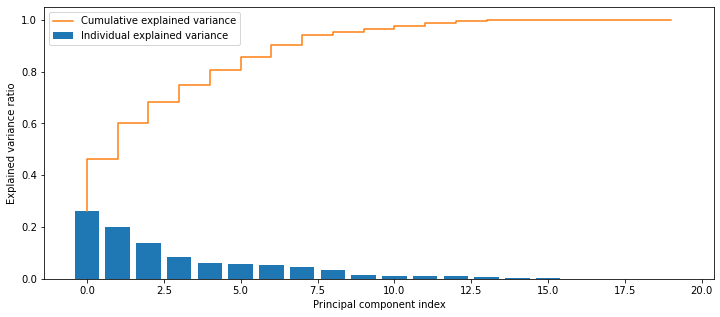

In [17]:
#Detection of the number of component needed
pca = PCA()
pca.fit(X_clean)

#Explained variance ratio analysis
exp_var = pca.explained_variance_ratio_
cumsum_exp_var = np.cumsum(exp_var)

plt.figure(figsize = (12,5))
plt.bar(range(0, len(exp_var)), exp_var, label = 'Individual explained variance', color = 'C0')
plt.step(range(0, len(cumsum_exp_var)), cumsum_exp_var, label = 'Cumulative explained variance', color = 'C1')
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.show()

To choose the rigth amount of variance keeping by PCA, we look plot of explained variance ratio. And we apply the elbow method to find the optimal ratio.  
Keeping 0.9 of the observed variance ratio is more than enough.

In [18]:
#Dimensionality reduction keeping O.9 explained variance ratio
pca = PCA(n_components = 0.9)
X_pca = pca.fit_transform(X_clean)
X_pca.shape

(99429, 8)

Now our data is ready, so we split it into a train and test set. For training our model and evaluate its performances. 

In [19]:
#Split into tran and test set
(X_train, 
 X_test,
 y_train,
 y_test) = train_test_split(X_clean, y, train_size=0.70, random_state=10)

In [20]:
#Shape verification 
for i, y in zip([y_train, y_test], ["train", "test"]) : 
    print(f"Shape of {y} set is {i.shape}")

Shape of train set is (69600,)
Shape of test set is (29829,)


### Modeling

We use simple linear model to solve this problem. Logistic Regression by default use gradient descent, but we work on a large dataset, so SGD Classifier would be better.
Stochastic Gradient Descent considers only 1 random point while changing weights unlike gradient descent which considers the whole training data. As such stochastic gradient descent is much faster than gradient descent when dealing with large datasets.

Moreover, we want to work with ROC curve analysis, so we use a loss definition that give a probabilistic classifier. And we penalize erros on minority classes because we are in an imbalanced classification problem.

In [42]:
#Bagging classifier
model= SGDClassifier(loss = 'log', class_weight = 'balanced')
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

As we have an imbalanced dataset, we use AUC score to evaluate the model performance.  
By mesuring the area under the ROC curve, we can compare precision on our imbalanced classes. First the ROC curve plots the true positive rate against the false positive rate. 

AUC is the area under the curve, a perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have ROC AUC equal to 0.5. Nevertheless, ROC AUC is usually used for binary classification, here we have a multiclassification problem. So to visualize the ROC AUC score, we use OvR method. One vs Rest ROC AUC score consist of compute the AUC of each class against the rest.

In [43]:
#AUC score One vs Rest
classes = [0, 1, 2]
labels = ["Galaxy", "Star", "Quasar"]

for i in range(len(classes)) : 
    c = classes[i]
    l = labels[i]

    #Auxiliars arrays for prediction
    y_aux = np.array([1 if y == c else 0 for y in y_test])
    y_aux_pred = np.array([1 if y == c else 0 for y in y_pred])

    print(f"ROC AUC score OvR {l} : {roc_auc_score(y_aux, y_aux_pred, average = 'weighted')}")

ROC AUC score OvR Galaxy : 0.9312553026769276
ROC AUC score OvR Star : 0.9576157556078918
ROC AUC score OvR Quasar : 0.9455720000188547


We have great result for each classes. 

With ROC curve there is a trade-off : the higher the TPR, the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier. A good classifier stays as far away from that line as possible (toward the top-left corner).

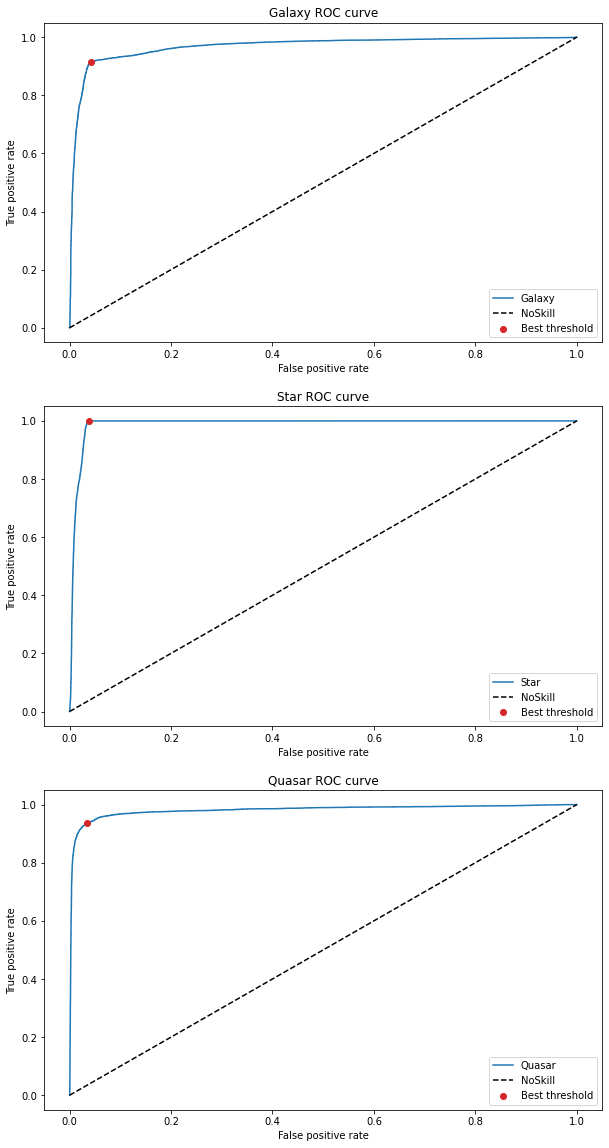

In [44]:
#ROC curve
y_scores = model.predict_proba(X_test)


plt.figure(figsize=(10,20))
for i, l, c in zip(range(len(classes)), labels, classes) :
    y_idx = y_scores[:, i]
    y_aux = np.array([1 if y == c else 0 for y in y_test])
    
    fpr, tpr, thresholds = roc_curve(y_aux, y_idx)

    #G-mean score
    gmeans = np.sqrt(tpr * (1-fpr))
    idx = np.argmax(gmeans)

    #Plot 
    plt.subplot(3, 1, i+1)
    plt.plot(fpr, tpr, label = l)
    plt.plot([0,1], [0,1], 'k--', label = "NoSkill")
    plt.scatter(fpr[idx], tpr[idx], marker = 'o', c = 'C3', label = "Best threshold", zorder = 3)
    plt.title(f"{l} ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc = "lower right")
plt.show()

As we said before, we have good results, we can see this because each of our ROC curves are towards the top-left corner. So we use the last way for evaluate classification algorithm (which is better understandable for business). Confusion matrix. 

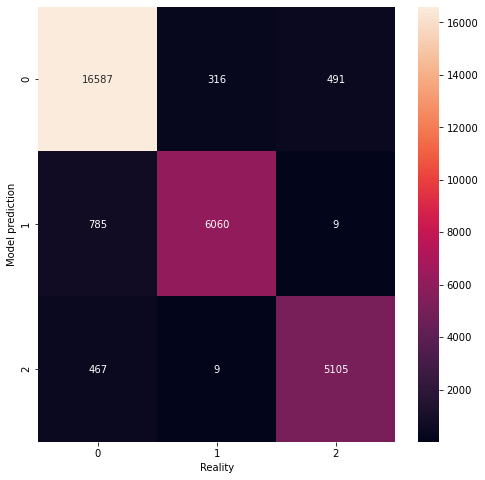

In [45]:
#Confusion matrix
plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt = 'g')
plt.xlabel("Reality")
plt.ylabel("Model prediction")
plt.show()

### Conclusion

In this project we have seen how to deal with outliers using LocalOutlierFactor, we have seen how to deal with higly correlated features using Principal Component Analysis and its prerequisites like normalization using StandardScaler, we have seen how to use Stochastic Gradient Descent for classification problem, its advantages and how to use class weigth to deal with imbalanced dataset. Moreover, we have seen how to use ROC AUC score with multi classification problem.  
To conclude, we can say that the preprocessing step is very important, and it helps a lot to get a good result. In our confusion matrix, we can see some errors, which is probably due to the imbalance of the dataset.